In [70]:
import polars.selectors as cs
import numpy as np

import polars as pl
import matplotlib as mpl
import matplotlib_inline.backend_inline

import matplotlib.pyplot as plt

LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.frameon'] = False


In [71]:
index_cols = {
    1: ['l_returnflag', 'l_linestatus'],
    3: ['l_orderkey','o_orderdate','o_shippriority'],
    4: ['o_orderpriority'],
    5: ['n_name'],
    6: [],
    7: ['supp_nation', 'cust_nation', 'l_year'], 
    8: ['o_year'],
    9: ['nation', 'o_year'],
    10: ['c_custkey', 'c_name', 'c_acctbal', 'c_phone', 'n_name', 'c_address', 'c_comment'],
    12: ['l_shipmode'],
    13: ['c_count'],
    14: [],
    
    17: [],
    19: [],
    20: [],
    21: ['s_name'],
    22: ['cntrycode']
}
scale_required = set([1,4, 5, 6, 7, 9, 12, 13, 17, 19, 21, 22])
# not 8, 14
# skip 3, skip 20
queries_to_run = [1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 17, 19, 21, 22]

In [72]:
q4_dp = {'1-URGENT': [1.5117655067070224,
  1.115290282381145,
  0.7414847472302021,
  0.5489781539940463,
  0.34369734869085405,
  0.24392194927991181,
  0.12891642215037355,
  0.034509951755375586,
  0.03511694188227311,
  0.03385139722675703],
 '2-HIGH': [1.5615131295829283,
  1.1283322721241278,
  0.7869071968315171,
  0.5691955181549209,
  0.3396626050588161,
  0.24000093904196476,
  0.135181560418701,
  0.035620465325025864,
  0.032255149506921814,
  0.03304783864981104],
 '3-MEDIUM': [1.5970726029871707,
  1.094754508313955,
  0.7762963838867764,
  0.5423074820289068,
  0.37157672710086875,
  0.2444211453605979,
  0.13542448684983685,
  0.035580745643532155,
  0.033952413847819905,
  0.033380166471294534],
 '4-NOT SPECIFIED': [1.5764544844432136,
  1.0976042053963153,
  0.7474603539126871,
  0.5285064716433713,
  0.3625636372348437,
  0.2354498836969627,
  0.1310023308391933,
  0.03344792046913564,
  0.03340256504894011,
  0.033838586047816185],
 '5-LOW': [1.587168367650374,
  1.0513520088894168,
  0.7768863355598147,
  0.5715867094598752,
  0.3826118158928961,
  0.24457649466849807,
  0.13770691008222954,
  0.03289781425590712,
  0.03523690608037226,
  0.034628714269366666]}

In [73]:
def graph_query1(full_df):
    print("Q1")
    q1_dict = {'pct_diff_avg_qty': "Average Quantity",
     'pct_diff_avg_price': "Average Price",
     'pct_diff_sum_disc_price': "Sum of Discounted Price",
     'pct_diff_sum_qty': "Sum of Quantity of Lineitems",
     'pct_diff_sum_base_price': "Sum of Base Price",
     'pct_diff_avg_disc': "Average Discount",
     'pct_diff_count_order': "Count of Lineitems",
     'pct_diff_sum_charge': "Sum of Total Price "}
    # Create 4x2 subplot grid
    fig, axes = plt.subplots(4, 2, figsize=(15,10), sharex=True)

    pct_diff_cols = [col for col in merged_df.columns if col.startswith('pct_diff')]
    returnflag = full_df['l_returnflag'].unique().sort()
    linestatus = full_df['l_linestatus'].unique().sort()

    # First pass: collect all y-data for each row to determine shared y-limits
    row_y_data = {row: [] for row in range(4)}

    for i, col in enumerate(pct_diff_cols):
        row = i // 2

        for flag in returnflag:
            for status in linestatus:
                group_data = (full_df
                             .filter(pl.col('l_linestatus') == status)
                             .filter(pl.col('l_returnflag') == flag)
                             .sort('mi'))
                y = group_data[col]
                if len(y.to_list()) > 0:
                    row_y_data[row].extend(y.to_list())

    # Calculate y-limits for each row
    row_y_limits = {}
    for row in range(4):
        if row_y_data[row]:
            y_min = min(row_y_data[row])
            y_max = max(row_y_data[row])
            # Add some padding
            y_range = y_max - y_min
            padding = y_range * 0.05
            row_y_limits[row] = (y_min - padding, y_max + padding)
        else:
            row_y_limits[row] = (0, 1)  # default range

    # Second pass: create the plots
    for i, col in enumerate(pct_diff_cols):
        row = i // 2
        col_idx = i % 2
        ax = axes[row, col_idx]

        for flag in returnflag:
            for status in linestatus:
                group_data = (full_df
                             .filter(pl.col('l_linestatus') == status)
                             .filter(pl.col('l_returnflag') == flag)
                             .sort('mi'))
                xs = [np.log2(x) for x in group_data['mi']]
                y = group_data[col]
                print(flag, status, y.to_list())
                if len(y.to_list()) > 0:
                    ax.plot(xs, y.to_list(),linestyle='dotted',
                        label=f'Return Flag: {flag}, Status: {status}', 
                        linewidth=3)

        # Set shared y-limits for this row
        ax.set_ylim(row_y_limits[row])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        # X-axis label for bottom row only
        if row == 3:  # bottom row
            ax.set_xlabel('Mutual Information (log scale)', fontsize=15)

        # Y-axis label only for left column
        if col_idx == 0:  # left column
            ax.set_ylabel('Relative\nError (%)', fontsize=15)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

        ax.set_title(f'Approximating {q1_dict[col]}', fontsize=20)
        ax.legend(fontsize=14)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('../figs/q1_results.png')

In [74]:
def graph_query14(full_df):
    print("Q14!")
    fig, ax = plt.subplots(figsize=(7.5, 2.5))

    xs = [np.log2(x) for x in full_df['mi']]
    y = full_df['pct_diff_promo_revenue']
    print(y.to_list())
    ax.plot(xs, y.to_list(), linestyle='dotted', linewidth=3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
    ax.set_ylabel(f'Relative \n Error (%)', fontsize=15)
    ax.set_title(f'Approximating Promo Revenue Percentage', fontsize=20)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../figs/q14_results.png')

In [75]:
def graph_query12(full_df):
    print("Q12")
    fig, axes = plt.subplots(2, 1, figsize=(7.5,5), sharex=True)
    for ind, key in enumerate(['pct_diff_high_line_count', 'pct_diff_low_line_count']):
        names = ["High", "Low"]
        ax = axes[ind]

        priorities = full_df['l_shipmode'].unique().sort()

        for priority in priorities:
            group_data = full_df.filter(pl.col('l_shipmode') == priority).sort('mi')
            xs = [np.log2(x) for x in group_data['mi']]
            y = group_data[f'pct_diff_{names[ind].lower()}_line_count']
            ax.plot(xs, y.to_list(),linestyle='dotted', linewidth=3,
                label=f'Ship Mode: {priority}'
            )
            print('priority')
            print(y.to_list())

            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)


        ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
        ax.set_ylabel(f'Relative \n Error (%)', fontsize=15)
        ax.set_title(f'Approximating {names[ind]} Line Count', fontsize=20)
        ax.legend(fontsize=14)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('../figs/q12_results.png')

In [76]:
def graph_query(full_df, query_ind):
    if query_ind == 1:
        graph_query1(full_df)
    if query_ind == 14:
        graph_query14(full_df)
    if query_ind == 4:
        graph_query4(full_df)
    if query_ind == 12:
        graph_query12(full_df)

In [77]:
def graph_query4(full_df):
    print("Q4!")
    fig, axes = plt.subplots(2, 1, figsize=(7.5,5), sharex=True)
    priorities = full_df['o_orderpriority'].unique().sort()
    labels = ["PAC", "DP"]
    for i in range(len(labels)):
        ax = axes[i]
        xs = [np.log2(x) for x in full_df['mi'].unique().sort().to_list()]
        if i == 0:
            print("PAC")
            for priority in priorities:
                group_data = full_df.filter(pl.col('o_orderpriority') == priority).sort('mi')
                
                y = group_data['pct_diff_order_count']
                ax.plot(xs, y.to_list(), linestyle='dotted',
                    label=f'Priority: {priority}', linewidth=3)
                print(priority, y.to_list())
        if i == 1:
            print("DP")
            for priority in priorities:
                ys = q4_dp[priority]
                print(priority, ys)
                ax.plot(xs, ys, linestyle='dotted', label=f'Priority: {priority}', linewidth=3)

        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
        ax.set_ylabel(f'Relative \n Error (%)', fontsize=15)
        ax.set_title(f'Approximating Order Count Difference % ({labels[i]})', fontsize=18)
        ax.grid(True, alpha=0.3)
        plt.subplots_adjust(hspace=0.6)  # hspace controls vertical spacing
    handles, labels_legend = axes[0].get_legend_handles_labels()
#         fig.legend(handles, labels_legend, bbox_to_anchor=(0.5, -0.01), 
#                   loc='upper center', ncol=3, fontsize=16)
    fig.legend(handles, labels_legend,
               loc='lower center', ncol=2, fontsize=14, bbox_to_anchor=(0.5, -0.2))

    plt.savefig('../figs/q4_results.png', bbox_inches='tight')

Q1
A F [0.33832127133633627, 0.2383398768639803, 0.1730550649042146, 0.12922155707266464, 0.0916257706729808, 0.07096437195825199, 0.06040904056374169, 0.05315104233113905, 0.04905503290983556, 0.04507449537901403]
A O []
N F [2.418107175643652, 1.6806504606005501, 1.2009509534365093, 0.8421654957751569, 0.6577177021412465, 0.49954326386230935, 0.4508227016496247, 0.35243655544423014, 0.3320861187602799, 0.3105949418799389]
N O [0.2212846319760727, 0.1560577368213933, 0.11732367952667351, 0.08372559415388207, 0.06064693211588558, 0.047607817860517584, 0.03926742980216901, 0.03340872501706724, 0.030286661139248165, 0.02855607460720684]
R F [0.35207990389766836, 0.2415149149605109, 0.17746241190796577, 0.13028345794713708, 0.09767334942311635, 0.07577561226699828, 0.062245182309426834, 0.052525979573344345, 0.048506399336220064, 0.04695230350942863]
R O []
A F [2.454825713807888, 1.715595899447979, 1.2286648957727515, 0.9069166847434594, 0.6750397472724289, 0.5143700296972504, 0.41999242

Q12
priority
[8.905498602849482, 6.593920082009656, 4.591484943582127, 3.315549172251339, 2.48808212847307, 1.9030929054676222, 1.621127460534767, 1.3428972361907627, 1.2358709506259906, 1.1962326224421058]
priority
[8.642132088499075, 6.056871444398576, 4.431707585024694, 3.2051623688152175, 2.3796767771436023, 1.8821481464372731, 1.546238438596236, 1.2826247024136623, 1.1705399260662694, 1.13743483960996]
priority
[7.0241211730940325, 4.6572535656030185, 3.4648691303258623, 2.560539916721874, 1.8312506898041279, 1.4527663221851215, 1.1534698074901801, 1.0144713355339365, 0.9309459714719805, 0.9487810583309827]
priority
[7.05014259584155, 5.180446624444215, 3.7189146398303836, 2.7019104554068045, 2.011445574809333, 1.6006579958100542, 1.2593876215918849, 1.0662812169855451, 1.0009103455516637, 0.9549011328139548]
Q14!
[6.078574629181784, 4.220518762678064, 2.922968309972097, 2.2317893717722153, 1.6338194593795645, 1.2613583199826772, 1.046924646120784, 0.8750531729171123, 0.7810305664

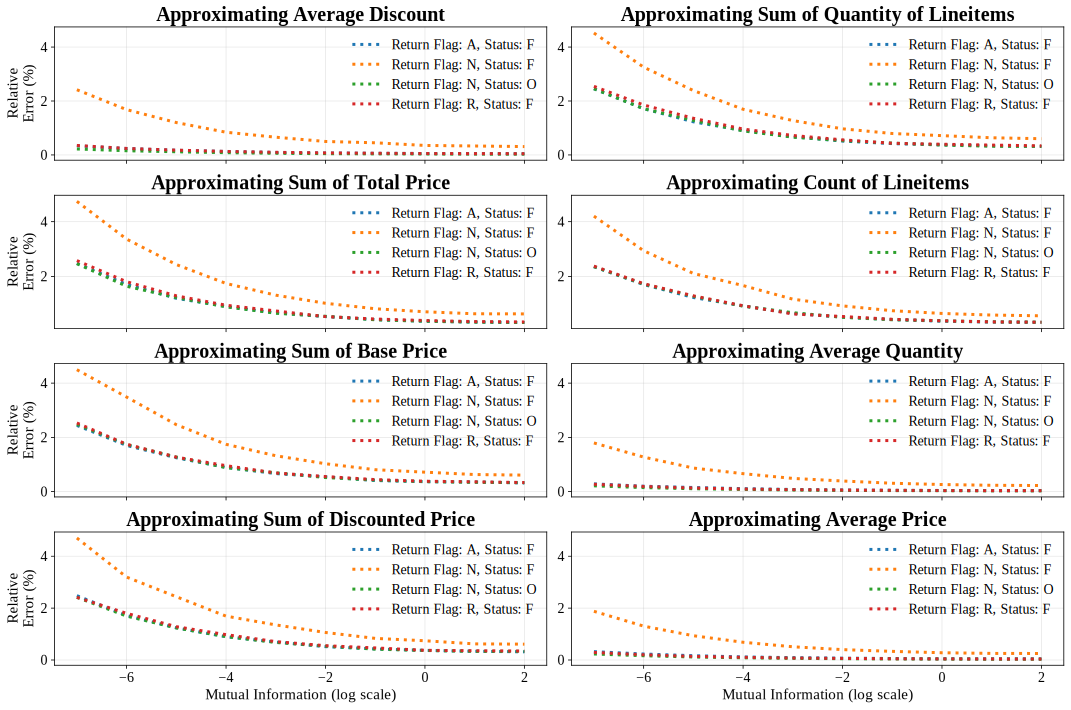

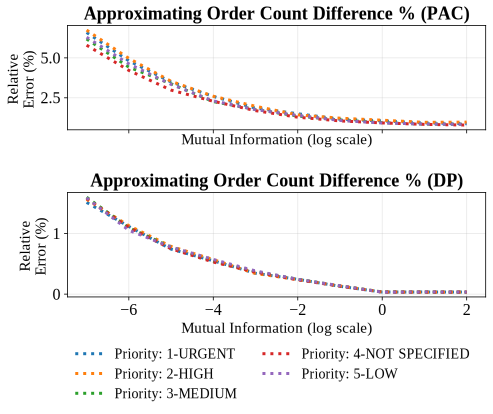

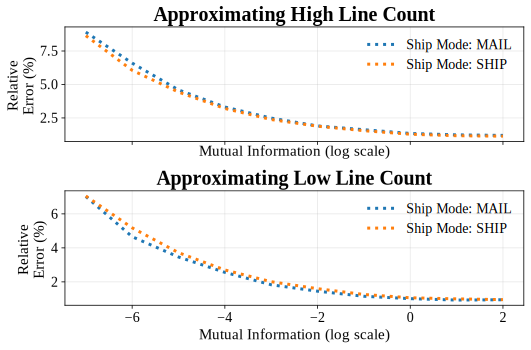

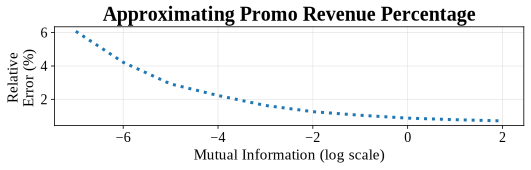

In [78]:
for query_ind in [1, 4, 12, 14]:
    full_df = pl.DataFrame()
    for mi in [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]:
        null_info = {}
        orig = pl.read_csv(f'../unnoised/q{query_ind}.csv')
        if query_ind == 22:
            orig = orig.select(
            pl.col("cntrycode").cast(str),
            pl.col("numcust"),
            pl.col("totacctbal"))
        if query_ind == 10:
            orig = orig.select(
                pl.col("c_custkey"), pl.col("c_name"),
                pl.col("c_acctbal").cast(str),
                pl.col("n_name"), pl.col("c_address"), pl.col("c_phone"), pl.col("c_comment")
            )
        noised = pl.read_json(f'../outputs/ap-duckdb-q{query_ind}-customer-{mi}-step3/output.json')
        if index_cols[query_ind]:
            merged_df = orig.join(noised, on=index_cols[query_ind], suffix='_noised')
        else:
            merged_df = orig.join(noised, suffix='_noised', how='cross')
        suffix1 = ''
        suffix2 = '_noised'
        cols_with_suffixes = [col for col in merged_df.columns if suffix1 in col or suffix2 in col]

        base_names = set([col.replace(suffix1, '').replace(suffix2, '') for col in cols_with_suffixes])
        for base_name in base_names:
            nulls_exist = False
            null_inds, null_vals = [], []

            orig = base_name + suffix1
            noised = base_name + suffix2
            if orig in merged_df.columns and noised in merged_df.columns:
                rel_errors = []
                for ind in range(len(merged_df[orig])):
                    if query_ind in scale_required:
                        const = 2 # subsampling scaling
                        if query_ind == 1 and not (base_name[:3] == 'sum' or base_name[:5] == 'count'):
                            const = 1 # remove for parts of q1
                    else:
                        const = 1
    #                     print(merged_df[noised][ind])
                    noised_vals = [merged_df[noised][ind][tmp_ind] for tmp_ind in range(
                        len(merged_df[noised][ind])) if merged_df[noised][ind][tmp_ind] is not None]
#                     print(merged_df[noised])
                    new = np.average(
                        [100*abs(
                            const*noised_vals[tmp_ind] - merged_df[orig][ind]
                            ) / merged_df[orig][ind] for tmp_ind in range(
                                len(noised_vals))]
                    )
                    rel_errors.append(new)
                merged_df = merged_df.with_columns(pl.Series('pct_diff_' + base_name, rel_errors))
                merged_df = merged_df.with_columns(pl.Series('mi', [mi]*len(rel_errors)))
        full_df = pl.concat([full_df, merged_df])
    graph_query(full_df, query_ind)

In [352]:
merged_df

cntrycode,numcust,totacctbal,numcust_noised,totacctbal_noised,pct_diff_totacctbal,mi,pct_diff_numcust
str,i64,f64,list[f64],list[f64],f64,f64,f64
"""13""",94,714035.05,"[42.084676, 43.802384, … 55.252967]","[425773.48438, 354169.607143, … 324793.705595]",9.296245,4.0,9.024428
"""17""",96,722560.15,"[55.649387, 47.717042, … 55.662594]","[391967.573331, 314564.988864, … 361014.447416]",9.157421,4.0,8.644821
"""18""",99,738012.52,"[53.683046, 54.899266, … 46.659914]","[373570.396622, 392772.207598, … 373938.955715]",8.200193,4.0,8.295165
"""23""",93,708285.25,"[44.186578, 44.535288, … 46.226075]","[307110.772619, 291312.076307, … 314530.389353]",8.396706,4.0,7.798526
"""29""",85,632693.46,"[46.442984, 48.59659, … 45.217466]","[308111.54203, 326945.237908, … 281311.605148]",8.940849,4.0,8.844086
"""30""",87,646748.02,"[42.448871, 44.185478, … 42.020701]","[319882.464539, 263976.052297, … 323154.471638]",8.888032,4.0,8.652735
"""31""",87,647372.5,"[33.573751, 46.783646, … 37.26892]","[278204.316048, 280446.375597, … 359604.839395]",10.432176,4.0,10.026485


In [79]:

avg_errors = {
    "Q2": 0.,
    "Q5": 25.622938327248313,
    "Q6": 3.975880395383505,
    "Q7": 26.254870522345144,
    "Q8": 120.43882910564585,
    "Q9": 23.271514480779384,
    "Q11": 0.,
    "Q13": 19.722793014350138,
    "Q15": 41.89916745531556,
    "Q16": 0.,
    "Q17": 39.95207812726525,
    "Q19": 85.3515578953771,
    "Q21": 68.63134006957296,
    "Q22": 25.083121818619354}



avg_errors_128 = {'Q2': 0,
 'Q5': 9.045629271965053,
 'Q6': 1.2860405483375585,
 'Q7': 9.017410097004426,
 'Q8': 35.822894463656,
 'Q9': 7.160786752071281,
 'Q11': 0,
 'Q12': 2.9457904782988082,
 'Q13': 13.58162708957928,
 'Q15': 34.50384808901249,
 'Q17': 11.455715445346588,
 'Q19': 23.48917728195702,
 'Q21': 63.56633656447392,
 'Q22': 7.795469260205711}

null_pct = {
    "Q3": 100,
    "Q13": 13.513513513513514,
    "Q10": 100,
    "Q18": 100,
    "Q21": 51.06382978723404,
}

null_pct_128 = {
    "Q3": 100,
    "Q13": 9.523809523809524,
    "Q10": 100,
    "Q18": 100,
    "Q21": 4.0
}

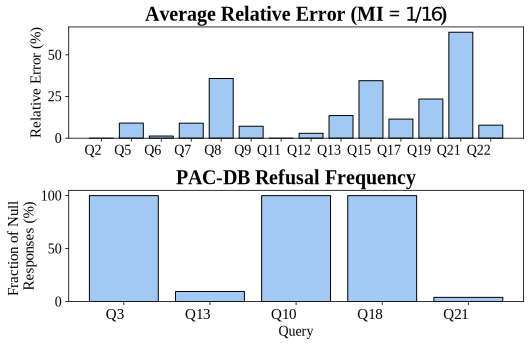

In [80]:
# Create the bar plot for unnoised times
import matplotlib as mpl
import matplotlib_inline.backend_inline

mpl.rcParams['savefig.dpi'] = 300

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.frameon'] = False


colors = ['#a1c9f4', '#8de5a1', '#ff9f9b', '#d0bbff', '#fffea3', '#b9f2f0']
cmap = mpl.colors.ListedColormap(colors)
bar1 = {'color': colors[0], 'edgecolor': 'k'}
bar2 = {'color': colors[1], 'edgecolor': 'k'}
bar3 = {'color': colors[2], 'edgecolor': 'k'}
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5, 5))

error_keys = avg_errors_128.keys()
error_vals = avg_errors_128.values()
ax1.bar(error_keys, error_vals, color=colors[0], edgecolor='k')
x = range(len(error_keys))
ax1.set_xticks(x, error_keys, ha='right', fontsize=14)
# ax1.set_xlabel('Query', fontsize=16)
ax1.set_ylabel('Relative Error (%)', fontsize=15)
ax1.tick_params(axis='y', labelsize=14)  # Set y-tick font size to 14
ax1.set_title("Average Relative Error (MI = $1/16$)", fontsize=20)


error_keys = null_pct_128.keys()
error_vals = null_pct_128.values()
ax2.bar(error_keys, error_vals,color=colors[0], edgecolor='k')
x = range(len(error_keys))
ax2.set_xticks(x, error_keys, ha='right', fontsize=15)
ax2.set_xlabel('Query', fontsize=14)
ax2.set_ylabel('Fraction of Null \nResponses (%)', fontsize=15)
ax2.tick_params(axis='y', labelsize=14)  # Set y-tick font size to 14
ax2.set_title("PAC-DB Refusal Frequency", fontsize=20)

plt.subplots_adjust(hspace=0.5)  # Add padding between plots
plt.tight_layout()
plt.savefig('../figs/overall_utility.png')